#For colab

In [272]:
import numpy as np
import pandas as pd
import collections
import json
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
"""
with open('..//data//daily_price_small.json') as json_file:
    json_data = json.load(json_file)
price_s = pd.read_json(json_data)

"""


#import price data
with open('/gdrive/My Drive/대학원 2학기/딥러닝/Deeplearning_pj/DL_final_proj/data/daily_price_small.json') as f:
    price_json = json.load(f)
price_s = pd.read_json(price_json)
"""

with open('/gdrive/My Drive/대학원 2학기/딥러닝/Deeplearning_pj/DL_final_proj/data/daily_price.json') as f:
    price_json = json.load(f)
price_s = pd.read_json(price_json)
"""

#import cluster data; industry code
with open('/gdrive/My Drive/대학원 2학기/딥러닝/Deeplearning_pj/DL_final_proj/data/industry_code.json') as f:
    industry_json = json.load(f)
industry_s = pd.read_json(industry_json)

#Del off-days 

#idx of double 
double_idx = np.full(len(price_s.index), False, dtype = bool)

for i in range(len(price_s.index)) :
    oneday_arr = price_s.values[i]
  
    if i ==0 :
        pre_arr = oneday_arr
        continue ;
    #get non np array for calc norm distance btw pre & curr day return 
    nz_idx = np.isnan(oneday_arr)

    if np.linalg.norm(oneday_arr[~nz_idx]  - pre_arr[~nz_idx]) < 0.001 :
        double_idx[i] = True
        

    pre_arr = oneday_arr

# Extract only working days
price_s = price_s.loc[price_s.index[~double_idx],:]
industry_s = industry_s.loc[industry_s.index[~double_idx],:]


In [0]:
#re-sizeing industry_s
dump_df = price_s.copy()
for col in price_s.columns :
    dump_df[col] = industry_s[col]
industry_s = dump_df

In [0]:
# there are some anormaly data with float and int
for column in industry_s.columns:
    industry_s[column] = industry_s[column].apply(lambda x : np.nan if type(x) == int or type(x) == float else x )


In [0]:
# get_industry_list 

df = pd.read_excel("/gdrive/My Drive/대학원 2학기/딥러닝/Deeplearning_pj/DL_final_proj/raw_data/Industry_code.xlsx")
df.columns = df.iloc[7]
df = df[13:]
df = df.set_index('Symbol')

for i in df.columns :
    if i == df.columns[0]:
        c = collections.Counter(df[i])
    c += collections.Counter(df[i])

industry_list = [*c.keys()]
#industry_list
industry_list = industry_list.remove(np.nan)



In [0]:
#get loading dic 
# 
industry_dic = {}
for industry in industry_list :
    #industry_dic.update({ industry :np.where(industry_s.values == industry, True, False)})
    industry_dic.update({ industry :np.where(industry_s.values == industry, 1, 0)})


In [199]:
#np.matrix(industry_dic[industry_list[0]]).shape
loading_m= industry_dic[industry_list[0]]

array([1, 1, 0, ..., 0, 0, 0])

cluster meanreversion 

In [263]:
#5 Day Mean reversion  
pr_rolling = price_s.rolling(21, min_periods=1).mean()
pr_rolling_ar = pr_rolling.values


input_data = pr_rolling
#input_data = pr_rolling
total_ammount = 1000000



portfolio = np.zeros(input_data.shape)
nn_price_s = np.where(np.isnan(input_data), 0, input_data)

for industry in industry_list :
    loading_m = industry_dic[industry]


    for i in range(len(input_data.index)) :
        if sum(loading_m[i]) == 0 :
            continue ;

        loading_return = np.multiply(loading_m[i] , nn_price_s[i])
        portfolio[i] += -1 * (loading_return - np.nanmean(loading_return))

abs_sum = np.sum(np.abs(portfolio), 1)
weight = total_ammount/abs_sum 
weight[total_ammount/abs_sum == np.inf] = 0
d = np.diag(weight)
portfolio_w = np.matmul(d, portfolio )



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


In [264]:
#make portfolio df with init zero
portfolio_df = price_s.copy()
for col in portfolio_df.columns:
    portfolio_df[col].values[:] = 0

portfolio_df.loc[:,:] = portfolio_w
portfolio_df = portfolio_df.shift(1)
portfolio_df.head(4)

,A005930,A000660,A035420,A005380,A207940,A068270,A012330,A051910,A055550,A051900,A028260,A017670,A005490,A034730,A105560,A000270,A015760,A006400,A018260,A096770,A032830,A033780,A035720,A003550,A036570,A090430,A010950,A066570,A000810,A086790,A316140,A009150,A009540,A010130,A011170,A251270,A002790,A030200,A024110,A035250,...,A032710,A037620,A038400,A042100,A045710,A045820,A051310,A053000,A060000,A063350,A063510,A064420,A067250,A068870,A069470,A076170,A079660,A101990,A103150,A103160,A104110,A104120,A108070,A110570,A114410,A117930,A121910,A122290,A122750,A192520,A192530,A272210,A308170,A317400,A322000,A900030,A900050,A950010,A950070,A950100
2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02,689.645305,-143.370707,-1141.921952,337.215454,337.215454,1650.817627,508.090533,112.941912,780.422691,-517.159943,337.215454,465.371764,-89.972244,337.215454,1576.059779,171.680221,785.762537,625.567150,337.215454,-3705.048143,337.215454,1592.079318,-517.159943,-292.886401,-1120.562567,-832.210871,508.090533,406.633455,-1115.222721,-1067.164105,337.215454,1592.079318,-479.781019,-554.538867,-501.140404,337.215454,-437.062249,481.391302,59.543450,-255.507478,...,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454
2009-01-05,-579.496056,-1949.065208,240.423392,-1192.917273,498.546181,632.162684,-2726.470314,-1381.195072,954.056986,1931.886846,498.546181,425.664452,-782.957549,498.546181,1023.901976,-1542.142223,188.798834,-275.822186,498.546181,-4099.076205,498.546181,483.362488,1731.462092,-1709.162851,-1715.236329,577.501387,52.145593,-558.238885,-327.446744,401.370543,498.546181,73.402764,-2173.783872,-1712.199590,-2504.788390,498.546181,1069.453056,-1038.043599,143.247754,161.468186,...,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181,498.546181
2009-01-06,-762.805602,-1721.986665,441.865074,-2951.965549,459.580819,193.844640,-1721.986665,-2218.027532,-1476.497053,3430.764376,459.580819,1122.655855,-1026.010960,459.580819,-2759.623172,-2367.345956,-512.254348,-631.202923,459.580819,-3933.923999,459.580819,1259.320175,1570.611127,-1742.233231,-833.668583,1317.529052,209.029565,-714.720008,107.796735,-2212.965890,459.580819,31.872113,-1944.698891,-3612.509764,-3987.071234,459.580819,1309.936590,-1716.925024,-2321.791182,550.690366,...,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819,459.580819


,A005930,A000660,A035420,A005380,A207940,A068270,A012330,A051910,A055550,A051900,A028260,A017670,A005490,A034730,A105560,A000270,A015760,A006400,A018260,A096770,A032830,A033780,A035720,A003550,A036570,A090430,A010950,A066570,A000810,A086790,A316140,A009150,A009540,A010130,A011170,A251270,A002790,A030200,A024110,A035250,...,A032710,A037620,A038400,A042100,A045710,A045820,A051310,A053000,A060000,A063350,A063510,A064420,A067250,A068870,A069470,A076170,A079660,A101990,A103150,A103160,A104110,A104120,A108070,A110570,A114410,A117930,A121910,A122290,A122750,A192520,A192530,A272210,A308170,A317400,A322000,A900030,A900050,A950010,A950070,A950100
2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02,689.645305,-143.370707,-1141.921952,337.215454,337.215454,1650.817627,508.090533,112.941912,780.422691,-517.159943,337.215454,465.371764,-89.972244,337.215454,1576.059779,171.680221,785.762537,625.567150,337.215454,-3705.048143,337.215454,1592.079318,-517.159943,-292.886401,-1120.562567,-832.210871,508.090533,406.633455,-1115.222721,-1067.164105,337.215454,1592.079318,-479.781019,-554.538867,-501.140404,337.215454,-437.062249,481.391302,59.543450,-255.507478,...,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454,337.215454
2009-01-05,-1276.126807,-2452.632671,1168.612495,-1818.515951,402.886645,-402.720760,-3960.155438,-1898.279060,670.093061,2923.400901,402.886645,211.455182,-961.062525,402.886645,167.585472,-2153.521010,-338.910272,-829.453395,402.886645,-2616.147045,402.886645,-554.270668,2660.182640,-2025.900035,-1415.712249,1379.984735,-310.993184,-1036.837479,402.886645,1324.150558,402.886645,-1092.671656,-2496.502381,-1834.468573,-2915.258705,402.886645,1730.942416,-1722.800220,143.656539,402.886645,...,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645,402.886645
2009-01-06,-707.660970,-246.885819,610.667934,-4950.632153,111.494854,-842.053723,1391.425829,-2697.953637,-5744.189357,4604.052576,111.494854,1941.796148,-944.448201,111.494854,-9136.006441,-2736.351566,-1693.207821,-1014.844404,111.494854,-1309.228529,111.494854,2165.784069,322.683465,-803.655793,1506.619617,2114.586830,418.678288,-630.865112,962.648952,-6441.751739,111.494854,-74.095138,-336.480988,-5526.601092,-4803.440091,111.494854,1058.643775,-2153.982972,-6172.966234,1052.244121,...,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854,111.494854


In [162]:
"""
이거 계산 빠르게 만들어야 함..
numpy matrix 연산으로 바꿔서 계산..
각 클러스터 마다 demean 된 수익률 메트릭스 가지고 매트릭스를 더하면 그게 포트폴리오
거기에 abs로 나누면되겠네.

"""


#make portfolio df with init zero
portfolio_df = price_s.copy()
for col in portfolio_df.columns:
    portfolio_df[col].values[:] = 0


#get portfolio matrix
day_list = price_s.index

for day_idx, day in enumerate(day_list) :
    if day_idx == len(day_list) -1:
        break ;

    for cluster in industry_list :
        daily_return_arr = price_s.values[day_idx]
        k_loading_arr = industry_dic[cluster][day_idx]
        nz_idx = np.isnan(daily_return_arr)
        k_mean_re = np.nanmean(daily_return_arr[k_loading_arr])

        #calc alpha 
        portfolio_df.loc[day_list[day_idx+1], k_loading_arr] = -1 * (daily_return_arr[k_loading_arr]- k_mean_re)
        portfolio_df.loc[day_list[day_idx+1], nz_idx] = 0



"""
i = 12
day = portfolio_df.index[0]
daily_return_arr = price_s.values[i]
k_loading_arr = industry_dic['I.005'][i]
nz_idx = np.isnan(daily_return_arr)

k_mean_re = np.nanmean(daily_return_arr[k_loading_arr])

#portfolio_df.loc[day, k_loading_arr] = -1 * (np.where(np.isnan(daily_return_arr[k_loading_arr]), 0, daily_return_arr[k_loading_arr]) - k_mean_re)
portfolio_df.loc[day, k_loading_arr] = -1 * (daily_return_arr[k_loading_arr]- k_mean_re)
portfolio_df.loc[day, nz_idx] = 0

"""


"""
checking portfolio weight
#np.nansum(portfolio_df.loc[day, k_loading_arr].values)
sum(portfolio_df.loc[day, k_loading_arr].values)

"""
#k_mean_re = (np.dot(daily_return_arr[~nz_idx],k_loading_arr[~nz_idx]))/np.nansum(k_loading_arr)
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


'\nchecking portfolio weight\n#np.nansum(portfolio_df.loc[day, k_loading_arr].values)\nsum(portfolio_df.loc[day, k_loading_arr].values)\n\n'

In [0]:
portfolio_df_2 = portfolio_df.copy()


price data랑 industry 데이터 종목 검토 필요
예상 시나리오 : price_s 가  필터링 된 종목일 것.
그러면 일단 price_small에 맞춰서  industry_loading matrix 재조정 필요.


In [0]:

#5 Day Mean reversion  
#pr_rolling = price_s.rolling(21, min_periods=1).mean()
#pr_rolling_ar = pr_rolling.values


#input_data = pr_rolling
input_data = price_s
total_ammount = 1000000

#make portfolio df with init zero
portfolio_df = price_s.copy()
for col in portfolio_df.columns:
    portfolio_df[col].values[:] = 0


#Calc  alpha
for i,index in enumerate(input_data.index) :
    
    if i == len(input_data.index)-1 :
        break ;
    day_pr_arr = input_data.values[i]
    weight_value = total_ammount/ np.sum(np.abs(day_pr_arr[~np.isnan(day_pr_arr)]))   

    alpha =  (day_pr_arr - np.nanmean(day_pr_arr))
    #alpha = -1 * (day_pr_arr -pr_rolling_ar[i] )
    alpha[~np.isnan(day_pr_arr)] = weight_value * alpha[~np.isnan(day_pr_arr)]
    
    portfolio_df.loc[input_data.index[i+1], :] = alpha


        
    

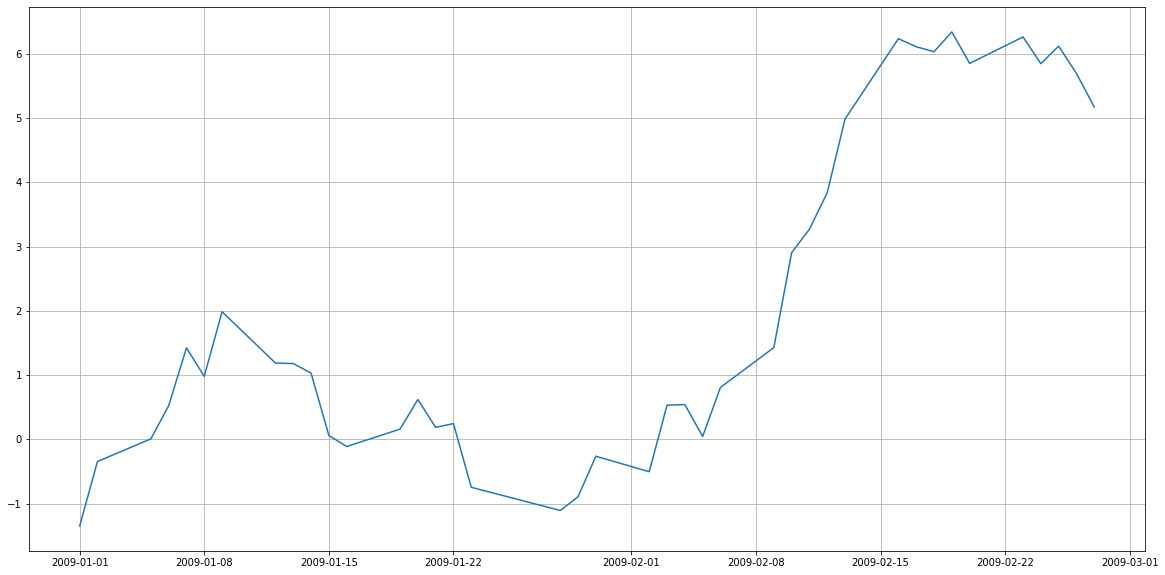

In [281]:
#back-testing by portfolio
price_arr = price_s.values
port_arr = portfolio_df.values
pf_p_l = np.zeros(len(port_arr))

for i in range(len(port_arr)) :
    a_2 = port_arr[i]
    a_1 = price_arr[i]
    pf_p_l[i] = np.inner(a_1[~np.isnan(a_1)], a_2[~np.isnan(a_1)])

p_and_l = np.cumsum(pf_p_l[1:])/total_ammount


pnl_s = pd.Series(p_and_l)
pnl_s.index = price_s.index[:-1]

from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(pnl_s)
plt.grid(b = True)

In [282]:
pnl_s

2009-01-01   -1.351158
2009-01-02   -0.346009
2009-01-05    0.006410
2009-01-06    0.522566
2009-01-07    1.422885
                ...   
2019-11-07         NaN
2019-11-08         NaN
2019-11-11         NaN
2019-11-12         NaN
2019-11-13         NaN
Length: 2688, dtype: float64

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(pnl_s)
plt.grid(b = True)

pf_p_l_s = pd.Series(pf_p_l)
pf_p_l_s.index = price_s.index
plt.figure(figsize=(20,10))
plt.plot(pf_p_l_s)
plt.grid(b = True)
#pf_p_l_s


#Del off days


In [0]:

#idx of double 
double_idx = np.full(len(w=1price_s.index), False, dtype = bool)

for i in range(len(price_s.index)) :
    oneday_arr = price_s.values[i]
  
    if i ==0 :
        pre_arr = oneday_arr
        continue ;
    #get non np array for calc norm distance btw pre & curr day return 
    nz_idx = np.isnan(oneday_arr)

    if np.linalg.norm(oneday_arr[~nz_idx]  - pre_arr[~nz_idx]) < 0.001 :
        double_idx[i] = True
        

    pre_arr = oneday_arr

# Extract only working days
real_price = price_s.loc[price_s.index[~double_idx],:]


#miscellaneous


In [0]:
price_s.values[0] - np.nanmean(price_s.values[0])
np.nan(np.nanprice_s.values[0])
np.isnan(price_s.values[0] )
day_pr_arr = price_s.values[0]
day_pr_arr_demean = day_pr_arr - np.nanmean(day_pr_arr)
total_ammount = 1000000
weight_value = total_ammount/ np.sum(np.abs(day_pr_arr[~np.isnan(day_pr_arr)]))
alpha = day_pr_arr_demean
alpha[~np.isnan(day_pr_arr)] = weight_value * alpha[~np.isnan(day_pr_arr)]
portfolio_df = price_s.copy()
for col in portfolio_df.columns:
    portfolio_df[col].values[:] = 0
portfolio_df.loc[price_s.index[1], :] = alpha